# Prep data

In [3]:
import sys
import time
from os import listdir
import gzip

from collections import Counter, Hashable, defaultdict
from itertools import chain, product

import numpy as np
from scipy import sparse
import random

In [4]:
chrom = '22'
m = 5
ped_file = '../data/160826.ped'
data_dir = '../split_gen_miss'

sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])

In [5]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}
chrom_length = chrom_lengths[chrom]

In [6]:
# genotype (pred, obs): cost
g_cost = {
	(-1, 0): 1,
	(-1, 1): 1,
	(-1, 2): 1,
	(0, 0): 0,
	(0, 1): 1,
	(0, 2): 2,
	(1, 0): 1,
	(1, 1): 0,
	(1, 2): 1,
	(2, 0): 2,
	(2, 1): 1,
	(2, 2): 0
}


In [7]:
# pull families with sequence data
with open(sample_file, 'r') as f:
	sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

# pull families from ped file
families = dict()
with open(ped_file, 'r') as f:	
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]

        if child_id in sample_ids and f_id in sample_ids and m_id in sample_ids:
        	if (fam_id, m_id, f_id) not in families:
        		families[(fam_id, m_id, f_id)] = [m_id, f_id]
        	families[(fam_id, m_id, f_id)].append(child_id)

# randomly permute children
families = dict([(k, x[:2]+random.sample(x[2:], len(x)-2)) for k, x in families.items()])
family_to_indices = dict([(fid, [sample_id_to_index[x] for x in vs]) for fid, vs in families.items()])
print('families with sequence data', len(families))

families_of_this_size = [(fkey, ind_indices) for fkey, ind_indices in family_to_indices.items() if len(ind_indices) == m]
print('families of size %d: %d' % (m, len(families_of_this_size)))

families with sequence data 886
families of size 5: 356


In [184]:
# inheritance states
#
#
# for parents:
# (0, 0) -> double deletion
# (0, 1) -> deletion on parental1
# (1, 0) -> deletion on parental2
# (1, 1) -> normal
# 
# for children:
# (0, 0) -> m1p1
# (0, 1) -> m1p2
# (1, 0) -> m2p1
# (1, 1) -> m2p2
#
# for family:
# (0) -> can't model
# (1) -> we're good

if m >= 5:
	inheritance_states = np.array(list(product(*([[0, 1]]*(2*m+1)))), dtype=np.int8)
else:
	inheritance_states = np.array([x for x in product(*([[0, 1]]*(2*m+1))) if x[4]==0 and x[5]==0], dtype=np.int8)

# parents aren't allowed to have deletions on a chromosome that no one inherits
# deletions are also not allowed in the family-0 (can't model state)
ok_states = []
state_len = inheritance_states.shape[1]
maternal_indices = range(4, state_len, 2)
paternal_indices = range(5, state_len, 2)
for i, s in enumerate(inheritance_states):
    if np.all(s[maternal_indices]!=0) and s[0] == 0:
        pass
    elif np.all(s[maternal_indices]!=1) and s[1] == 0:
        pass
    elif np.all(s[paternal_indices]!=0) and s[2] == 0:
        pass
    elif np.all(s[paternal_indices]!=1) and s[3] == 0:
        pass
    elif np.any(s[:4]==0) and s[-1] == 0:
        pass
    else:
        ok_states.append(i)

# parents aren't allowed to have deletions unless both chromosomes are inherited
#for i, s in enumerate(inheritance_states):
#    if (np.all(s[maternal_indices]!=0) or np.all(s[maternal_indices]!=1)) and (s[0] == 0 or s[1] == 0):
#        pass
#    elif (np.all(s[paternal_indices]!=0) or np.all(s[paternal_indices]!=1)) and (s[2] == 0 or s[3] == 0):
#        pass
#    else:
#        ok_states.append(i)
inheritance_states = inheritance_states[ok_states, :]


state_to_index = dict([(tuple(x), i) for i, x in enumerate(inheritance_states)])
p = inheritance_states.shape[0]
print('inheritance states', inheritance_states.shape)

inheritance states (904, 11)


In [250]:
# transition matrix
# only allow one shift at a time
shift_costs = [10]*4 + [500]*(2*(m-2)) + [500]

transitions = [[] for i in range(p)]
transition_costs = [[] for i in range(p)]
for i, state in enumerate(inheritance_states):
	for delstate in list(product(*[[0, 1]]*5)):
		new_state = tuple(delstate[:4]) + tuple(state[4:-1]) + (delstate[-1],)
		if new_state in state_to_index:
			new_index = state_to_index[new_state]
			transitions[i].append(new_index)
			transition_costs[i].append(sum([shift_costs[j] for j, (old_s, new_s) in enumerate(zip(state[:4] + [state[-1]], delstate)) if old_s != new_s]))

	# allow a single recombination event
	for j in range(4, inheritance_states.shape[1]-1):
		if state[-1] == 1: # only allow recombination in family-1
			new_state = tuple(1-x if k == j else x for k, x in enumerate(state))
			if new_state in state_to_index:
				new_index = state_to_index[new_state]
				transitions[i].append(new_index)
				transition_costs[i].append(shift_costs[j])
            

maxtrans = max([len(k) for k in transitions])
for i, trans in enumerate(transitions):
    num_trans = len(trans)
    trans.extend([i]*(maxtrans-num_trans))
    transition_costs[i].extend([0]*(maxtrans-num_trans))
transitions = np.array(transitions)
transition_costs = np.array(transition_costs)
print(transitions.shape)
print(transition_costs.shape)

(904, 23)
(904, 23)


In [251]:
starting_state = (1, 1, 1, 1, 0, 0)
zero_transition_costs = np.zeros((p,), dtype=int)
for i, ss in enumerate(starting_state):
	zero_transition_costs[inheritance_states[:, i] != ss] += shift_costs[i]
    
print('transitions', transitions.shape)

transitions (904, 23)


In [190]:
# perfect match genotypes
pm_gen_to_index = dict()
pm_gen_indices = []
for s in inheritance_states:
    anc_pos = [[-1] if s[i] == 0 else [0, 1] for i in range(4)]
    anc_variants = np.array(list(product(*anc_pos)), dtype=np.int8)
    pred_gens = np.zeros((anc_variants.shape[0], m), dtype=np.int8)

    # mom
    # deletion
    pred_gens[(anc_variants[:, 0]==-1) & (anc_variants[:, 1]==-1), 0] = -1
    pred_gens[(anc_variants[:, 0]==-1) & (anc_variants[:, 1]==0), 0] = 0
    pred_gens[(anc_variants[:, 0]==-1) & (anc_variants[:, 1]==1), 0] = 2
    pred_gens[(anc_variants[:, 0]==0) & (anc_variants[:, 1]==-1), 0] = 0
    pred_gens[(anc_variants[:, 0]==1) & (anc_variants[:, 1]==-1), 0] = 2
    # normal
    pred_gens[(anc_variants[:, 0]==0) & (anc_variants[:, 1]==0), 0] = 0
    pred_gens[(anc_variants[:, 0]==1) & (anc_variants[:, 1]==1), 0] = 2
    pred_gens[(anc_variants[:, 0]==0) & (anc_variants[:, 1]==1), 0] = 1
    pred_gens[(anc_variants[:, 0]==1) & (anc_variants[:, 1]==0), 0] = 1

    # dad
    # deletion
    pred_gens[(anc_variants[:, 2]==-1) & (anc_variants[:, 3]==-1), 1] = -1
    pred_gens[(anc_variants[:, 2]==-1) & (anc_variants[:, 3]==0), 1] = 0
    pred_gens[(anc_variants[:, 2]==-1) & (anc_variants[:, 3]==1), 1] = 2
    pred_gens[(anc_variants[:, 2]==0) & (anc_variants[:, 3]==-1), 1] = 0
    pred_gens[(anc_variants[:, 2]==1) & (anc_variants[:, 3]==-1), 1] = 2
    # normal
    pred_gens[(anc_variants[:, 2]==0) & (anc_variants[:, 3]==0), 1] = 0
    pred_gens[(anc_variants[:, 2]==1) & (anc_variants[:, 3]==1), 1] = 2
    pred_gens[(anc_variants[:, 2]==0) & (anc_variants[:, 3]==1), 1] = 1
    pred_gens[(anc_variants[:, 2]==1) & (anc_variants[:, 3]==0), 1] = 1

    # children
    for index in range(m-2):
        mat, pat = s[(4+(2*index)):(6+(2*index))]

        # deletion
        pred_gens[(anc_variants[:, mat]==-1) & (anc_variants[:, 2+pat]==-1), 2+index] = -1
        pred_gens[(anc_variants[:, mat]==-1) & (anc_variants[:, 2+pat]==0), 2+index] = 0
        pred_gens[(anc_variants[:, mat]==-1) & (anc_variants[:, 2+pat]==1), 2+index] = 2
        pred_gens[(anc_variants[:, mat]==0) & (anc_variants[:, 2+pat]==-1), 2+index] = 0
        pred_gens[(anc_variants[:, mat]==1) & (anc_variants[:, 2+pat]==-1), 2+index] = 2
        # normal
        pred_gens[(anc_variants[:, mat]==0) & (anc_variants[:, 2+pat]==0), 2+index] = 0
        pred_gens[(anc_variants[:, mat]==1) & (anc_variants[:, 2+pat]==1), 2+index] = 2
        pred_gens[(anc_variants[:, mat]==0) & (anc_variants[:, 2+pat]==1), 2+index] = 1
        pred_gens[(anc_variants[:, mat]==1) & (anc_variants[:, 2+pat]==0), 2+index] = 1

    unique_pred_gens = set(map(tuple, pred_gens))
    for pg in unique_pred_gens:
        if pg not in pm_gen_to_index:
            pm_gen_to_index[pg] = len(pm_gen_to_index)
    pm_gen_indices.append([pm_gen_to_index[pg] for pg in unique_pred_gens])

pm_gen = np.zeros((len(pm_gen_to_index), m), dtype=np.int8)
for pm, i in pm_gen_to_index.items():
	pm_gen[i, :] = pm
print('perfect matches', pm_gen.shape, Counter([len(v) for v in pm_gen_indices]))

perfect matches (328, 5) Counter({4: 314, 8: 232, 2: 188, 16: 96, 1: 42, 15: 32})


In [191]:
genotypes = np.array(list(product(*[[0, 1, 2]]*m)), dtype=np.int8)
genotype_to_index = dict([(tuple(x), i) for i, x in enumerate(genotypes)])
q = genotypes.shape[0]
print('genotypes', genotypes.shape)

losses = np.zeros((p, q), dtype=np.int8)
already_calculated = np.zeros((q,), dtype=bool)
def calculate_loss(gen): 
	gen_index = genotype_to_index[tuple(gen)]
	if not already_calculated[gen_index]:
		s = np.zeros((len(pm_gen_to_index),), dtype=np.int8)
		for pm, i in pm_gen_to_index.items():
			s[i] = sum([g_cost[(pred, obs)] for pred, obs in zip(pm, gen)])
		for i, indices in enumerate(pm_gen_indices):
			losses[i, gen_index] = np.min(s[indices])
		losses[inheritance_states[:, -1]==0, gen_index] = 0       
		already_calculated[gen_index] = True
	return losses[:, gen_index]

genotypes (243, 5)


In [15]:
# pull genotype data from .npz
indices_of_interest = sum([v for k, v in families_of_this_size], [])
old_index_to_new_index = dict([(ind, i) for (i, ind) in enumerate(indices_of_interest)])
families_of_this_size = [(k, [old_index_to_new_index[x] for x in v]) for (k, v) in families_of_this_size]

whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[indices_of_interest,:] for gen_file in gen_files])
	
# use only "cleaned" variants - must be SNPs
coordinates = np.load(coord_file)
snp_positions = coordinates[:, 1]
snp_indices = coordinates[:, 2]==1

whole_chrom = whole_chrom[:, snp_indices]
snp_positions = snp_positions[snp_indices]
total_inds, n = whole_chrom.shape
print('chrom shape only SNPs', total_inds, n)

chrom shape only SNPs 1780 1004649


In [245]:
#fkey, ind_indices = random.choice(families_of_this_size)
#fkey = ('AU0941', 'AU0941202', 'AU0941201')
#fkey = ('AU0021', 'AU002101', 'AU002102')
#fkey = ('AU0625', 'AU062501', 'AU062502')
#fkey = ('AU0453', 'AU045301', 'AU045302')
#fkey = ('AU1210', 'AU1210202', 'AU1210201')
#fkey = ('AU1497', 'AU1497202', 'AU1497201')
#fkey = ('AU0905', 'AU0905202', 'AU0905201')
#fkey = ('AU0453', 'AU045301', 'AU045302')

#fkey = ('AU0897', 'AU0897202', 'AU0897201')
fkey = ('AU0809', 'AU080901', 'AU080902')
fkey, ind_indices = [x for x in families_of_this_size if x[0] == fkey][0]

In [252]:
inds = families[fkey]
print('family', fkey)

# pull genotype data for this family
family_genotypes = whole_chrom[ind_indices, :].A

# if any family member is missing, set whole family to 0 - this has the effect of ignoring missing positions
family_genotypes[:, np.any(family_genotypes<0, axis=0)] = 0

family_whole_chrom = np.zeros((m, chrom_length), dtype=np.int8)
family_whole_chrom[:, snp_positions-1] = family_genotypes

# condense repeated genotypes
rep_indices = np.where(np.any(family_whole_chrom[:, 1:]!=family_whole_chrom[:, :-1], axis=0))[0]

family_genotypes = family_whole_chrom[:, rep_indices]
family_genotypes = np.append(family_genotypes, family_whole_chrom[:, -1][:, np.newaxis], axis=1)
print(family_genotypes.shape)
n = family_genotypes.shape[1]

family_snp_positions = np.zeros((n, 2), dtype=int)
family_snp_positions[0, 0] = 0
family_snp_positions[-1, 1] = chrom_lengths[chrom]
family_snp_positions[1:, 0] = (rep_indices+1)
family_snp_positions[:-1, 1] = (rep_indices+1)
mult_factor = family_snp_positions[:, 1] - family_snp_positions[:, 0]


# viterbi
v_cost = np.zeros((p, n), dtype=int)

# forward sweep
prev_time = time.time()

# first step, break symmetry
# we enforce that the chromosome starts with child1 (0, 0) and no deletions or duplications
pos_gen = tuple(family_genotypes[:, 0])
loss = calculate_loss(pos_gen).astype(int)
#loss = losses[:, genotype_to_index[pos_gen]].astype(int)
v_cost[:, 0] = mult_factor[0]*loss + zero_transition_costs

# next steps
no_model_states = np.where(inheritance_states[:, -1]==0)[0]
for j in range(1, n): 
	pos_gen = tuple(family_genotypes[:, j])
	loss = calculate_loss(pos_gen).astype(int)
	#loss = losses[:, genotype_to_index[pos_gen]].astype(int)
	v_cost[:, j] = np.min(v_cost[transitions, j-1] + transition_costs, axis=1) + mult_factor[j]*loss
	v_cost[no_model_states, j] += ((np.random.randint(10, size=no_model_states.shape[0])==0))

print('Forward sweep complete', time.time()-prev_time, 'sec') 

family ('AU0809', 'AU080901', 'AU080902')
(5, 142483)
Forward sweep complete 44.098206996917725 sec


In [253]:
# backward sweep
prev_time = time.time()
final_states = -np.ones((state_len, n), dtype=int)
final_cost = np.zeros((n,), dtype=int)

# choose best paths
# we enforce that the chromosome ends with no deletions
num_forks = 0
no_delstates = np.all(inheritance_states[:, :4]==1, axis=1)
min_value = np.min(v_cost[no_delstates, -1])
paths = np.where((v_cost[:, -1]==min_value) & no_delstates)[0]
print('Num solutions', paths.shape, inheritance_states[paths, :])

# combine path states into a single state (unknown values represented with -1)
if paths.shape[0] == 1:
	final_states[:, -1] = inheritance_states[paths[0], :]
else:
	num_forks += 1
	path_states = inheritance_states[paths, :]
	known_indices = np.all(path_states == path_states[0, :], axis=0)
	final_states[known_indices, -1] = path_states[0, known_indices]

# now work backwards
for j in reversed(range(n-1)):

	# traceback
	total_cost = v_cost[transitions[paths, :], j] + transition_costs[paths, :]
	min_value = np.min(total_cost, axis=1)
	new_paths = set()
	for i, k in enumerate(paths):
		min_indices = transitions[k, np.where(total_cost[i, :] == min_value[i])[0]]	
		new_paths.update(min_indices.tolist())
	paths = np.asarray(list(new_paths), dtype=int)

	# combine path states a single state (unknown values represented with -1)
	avg_cost = 0
	if paths.shape[0] == 1:
		final_states[:, j] = inheritance_states[paths[0], :]
		pos_gen = tuple(family_genotypes[:, j])
		if final_states[-1, j] == 0:
			final_cost[j] = -1
		else:
			final_cost[j] = calculate_loss(pos_gen).astype(int)[paths[0]]*mult_factor[j]
        
	else:
		num_forks += 1
		path_states = inheritance_states[paths, :]
		known_indices = np.all(path_states == path_states[0, :], axis=0)
		final_states[known_indices, j] = path_states[0, known_indices]
		final_cost[j] = 0

print('Num positions in fork', num_forks)
print('Backward sweep complete', time.time()-prev_time, 'sec') 

Num solutions (1,) [[1 1 1 1 1 0 0 0 0 0 0]]
Num positions in fork 291
Backward sweep complete 7.968288898468018 sec


In [ ]:
# if a parental chromosome isn't inherited, then we don't know if it has a deletion
maternal_indices = range(4, state_len, 2)
paternal_indices = range(5, state_len, 2)

final_states[0, np.all(final_states[maternal_indices, :]!=0, axis=0)] = -1
final_states[1, np.all(final_states[maternal_indices, :]!=1, axis=0)] = -1
final_states[2, np.all(final_states[paternal_indices, :]!=0, axis=0)] = -1
final_states[3, np.all(final_states[paternal_indices, :]!=1, axis=0)] = -1

# Check VCF

In [40]:
orig_family_genotypes = whole_chrom[ind_indices, :].A
# if any family member is missing, set whole family to 0 - this has the effect of ignoring missing positions
orig_family_genotypes[:, np.any(orig_family_genotypes<0, axis=0)] = 0
print(orig_family_genotypes.shape, family_genotypes.shape, mult_factor.shape)

(5, 1004649) (5, 159395) (159395,)


In [41]:
print(np.sum(orig_family_genotypes==1, axis=1), np.sum((family_genotypes==1)*mult_factor, axis=1))
print(np.sum(orig_family_genotypes==2, axis=1), np.sum((family_genotypes==2)*mult_factor, axis=1))

[35569 36918 33974 33648 36038] [35569 36918 33974 33648 36038]
[15375 14535 15201 16295 15160] [15375 14535 15201 16295 15160]


In [236]:
print(inds)

['AU1399202', 'AU1399201', 'AU1399303', 'AU1399302', 'AU1399301']


In [254]:

f = np.convolve(final_cost, np.ones(1000,), mode='same')

In [255]:
print(np.sum(f<0)/f.shape[0])

0.6852115690994716


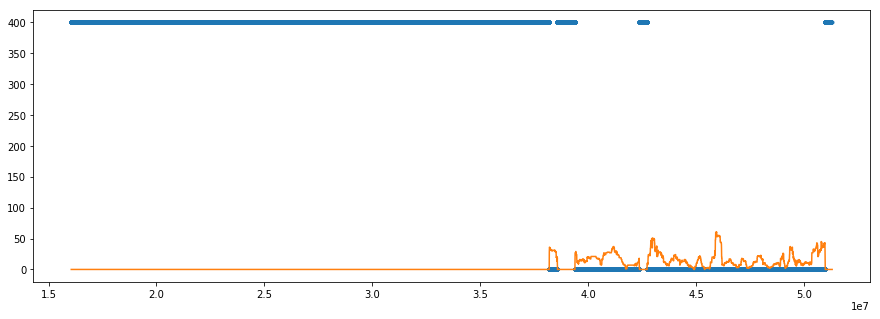

In [260]:
plt.figure(figsize=(15, 5))
#plt.plot(a)
#plt.plot(b)
#plt.plot(c)
#plt.plot(d)
#plt.plot(np.clip(e, 0, None))
plt.plot(family_snp_positions[:, 1], 400*(f<0), '.')
plt.plot(family_snp_positions[:, 1], np.clip(f, 0, None))
plt.show()

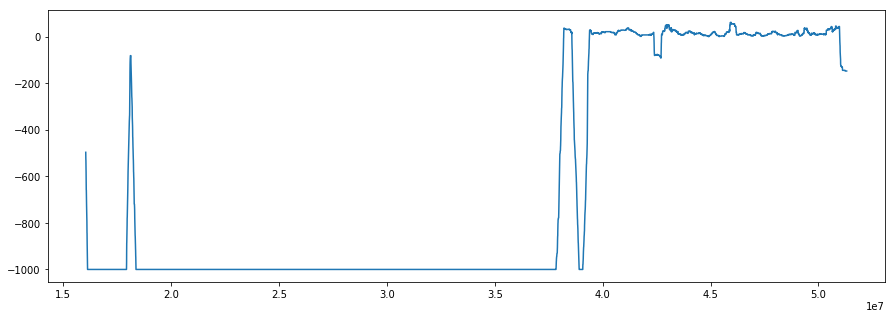

In [259]:
plt.figure(figsize=(15, 5))
plt.plot(family_snp_positions[:, 1], f)
plt.show()

In [58]:
print(family_genotypes[:, :20])
print(family_snp_positions[:20, :])

[[0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0]]
[[       0 16050035]
 [16050035 16050036]
 [16050036 16050158]
 [16050158 16050159]
 [16050159 16050251]
 [16050251 16050252]
 [16050252 16050611]
 [16050611 16050612]
 [16050612 16050821]
 [16050821 16050822]
 [16050822 16050932]
 [16050932 16050933]
 [16050933 16051248]
 [16051248 16051249]
 [16051249 16051346]
 [16051346 16051347]
 [16051347 16051496]
 [16051496 16051497]
 [16051497 16051967]
 [16051967 16051968]]


In [51]:
import gzip

with gzip.open('../data/22.reheader.vcf.gz', 'rb') as f:
    # skip header
    line = next(f).decode("utf-8") 
    while line.startswith('##'):
        line = next(f).decode("utf-8") 
        pass
    
    sample_ids = line.strip().split('\t')[9:]
    sample_id_to_index = dict([(x, i) for i, x in enumerate(sample_ids)])
    indices_of_interest = [sample_id_to_index[s] for s in inds]
    print([sample_ids[x] for x in indices_of_interest])
    
    for _ in range(10):
        pieces = next(f).decode("utf-8").strip().split('\t')
        gens = [pieces[i+9][:3] for i in indices_of_interest]
        print(pieces[1], gens)
    #print(next(f).strip().split())

['AU0897202', 'AU0897201', 'AU0897303', 'AU0897302', 'AU0897301']
16050007 ['0/0', './.', '0/0', './.', './.']
16050036 ['1/1', '0/0', '0/0', '0/0', '0/0']
16050102 ['0/0', '0/0', '0/0', '0/0', '0/0']
16050115 ['0/0', '0/0', '0/0', '0/0', '0/0']
16050116 ['0/0', '0/0', '0/0', '0/0', '0/0']
16050129 ['0/0', '0/0', '0/0', '0/0', '0/0']
16050137 ['0/0', '0/0', '0/0', '0/0', '0/0']
16050159 ['0/0', '0/0', '0/0', '0/1', '0/0']
16050199 ['0/0', '0/0', '0/0', '0/0', '0/0']
16050213 ['0/0', '0/0', '0/0', '0/0', '0/0']


# Shape results

In [21]:
change_indices = [-1] + np.where(np.any(final_states[:, 1:]!=final_states[:, :-1], axis=0))[0].tolist()

In [264]:
print(family_snp_positions[1, :])

[16050158 16050159]


In [265]:
print(inds)

['AU045301', 'AU045302', 'AU045306', 'AU045303', 'AU045304']


In [261]:
print(family_genotypes[:, 1])

[0 0 1 0 0]


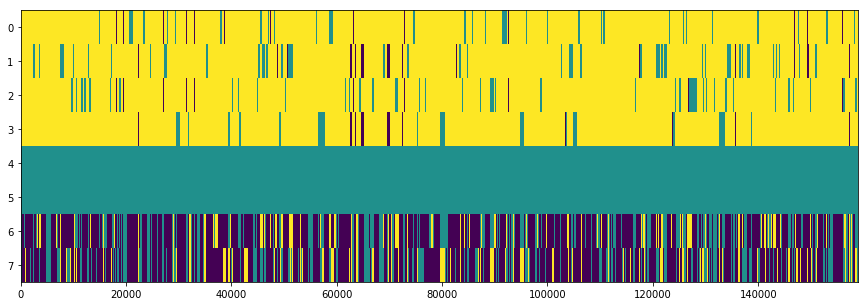

In [40]:
# transition cost = 0
plt.figure(figsize=(15, 5))
plt.imshow(final_states[:, change_indices], aspect='auto', vmin=-1, vmax=1)
plt.show()

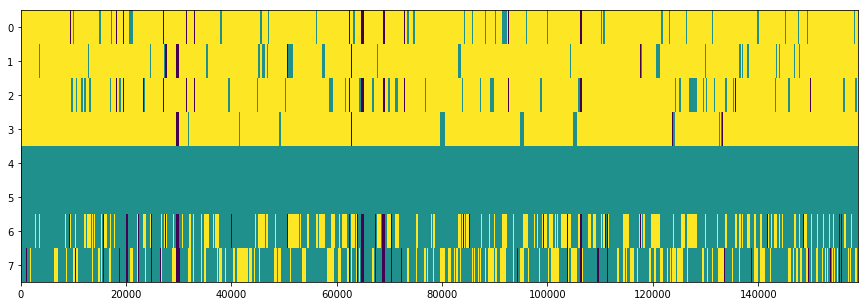

In [45]:
# transition cost = 10
plt.figure(figsize=(15, 5))
plt.imshow(final_states[:, change_indices], aspect='auto', vmin=-1, vmax=1)
plt.show()

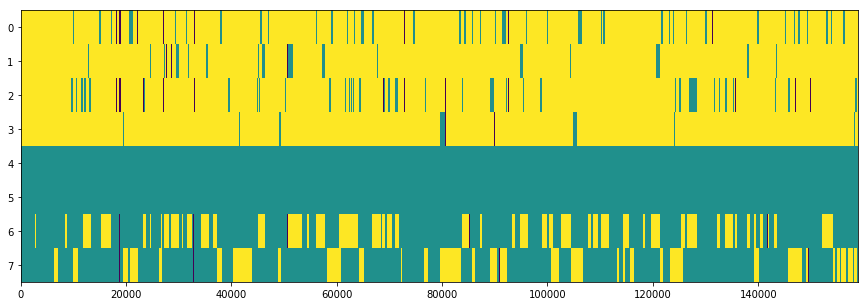

In [50]:
# transition cost = 50
plt.figure(figsize=(15, 5))
plt.imshow(final_states[:, change_indices], aspect='auto', vmin=-1, vmax=1)
plt.show()

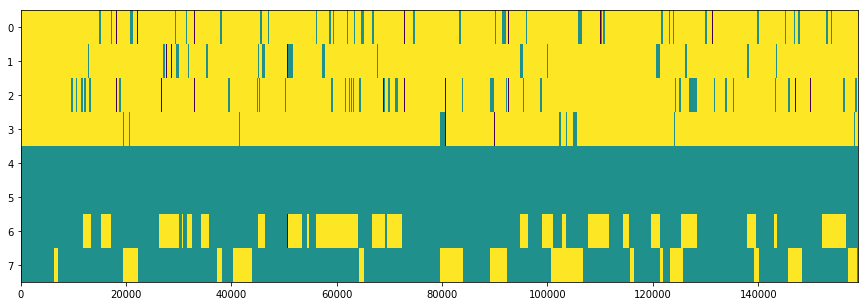

In [55]:
# transition cost = 100
plt.figure(figsize=(15, 5))
plt.imshow(final_states[:, change_indices], aspect='auto', vmin=-1, vmax=1)
plt.show()

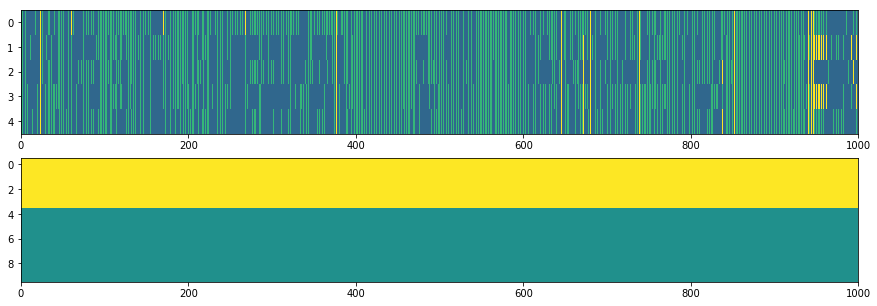

In [241]:
start = 0
end = 1000

plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.imshow(family_genotypes[:, start:end], aspect='auto', vmin=-1, vmax=2)
plt.subplot(2, 1, 2)
plt.imshow(final_states[:, start:end], aspect='auto', vmin=-1, vmax=1)

plt.show()

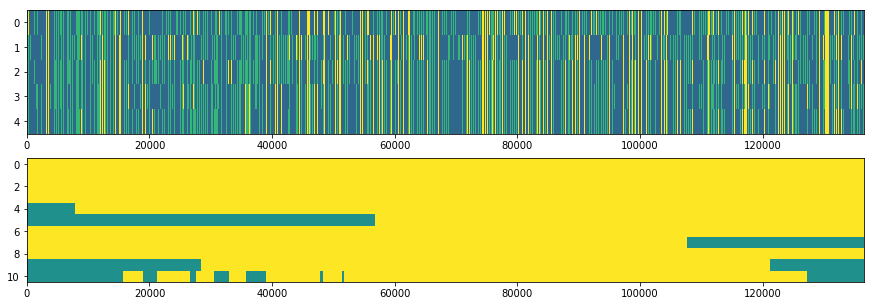

In [242]:
#start = np.where(np.any(final_states[:4, :]==0, axis=0))[0][1000]-500
#end = start+1000

plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.imshow(family_genotypes, aspect='auto', vmin=-1, vmax=2)
plt.subplot(2, 1, 2)
plt.imshow(final_states, aspect='auto', vmin=-1, vmax=1)

plt.show()

In [251]:
print(inds)
print(ind_indices)

['AU045301', 'AU045302', 'AU045306', 'AU045303', 'AU045304']
[1550, 1551, 1552, 1553, 1554]


In [184]:
w = whole_chrom[ind_indices, :].A
print(np.sum((w[4, :]>0) & (w[0, :] == 0) & (w[1, :] == 0)))

34464


In [187]:
print(np.sum(np.any(w>0, axis=0)))

207472


In [188]:
34464/207472


0.16611398164571606

In [185]:
print(family_genotypes.shape)

(5, 409641)


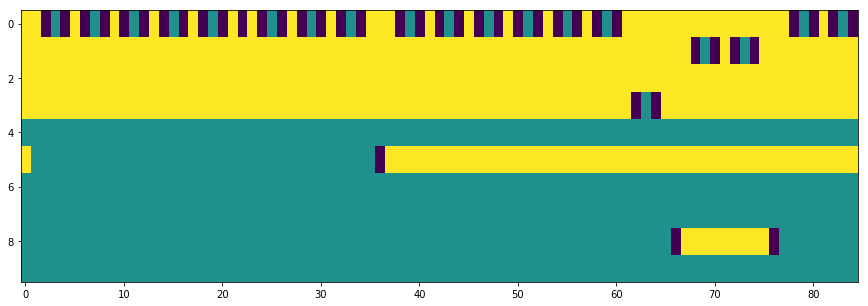

In [42]:
import matplotlib.pyplot as plt

change_indices = [-1] + np.where(np.any(final_states[:, 1:]!=final_states[:, :-1], axis=0))[0].tolist()

plt.figure(figsize=(15, 5))
plt.imshow(final_states[:, change_indices], aspect='auto', vmin=-1, vmax=1)
plt.show()

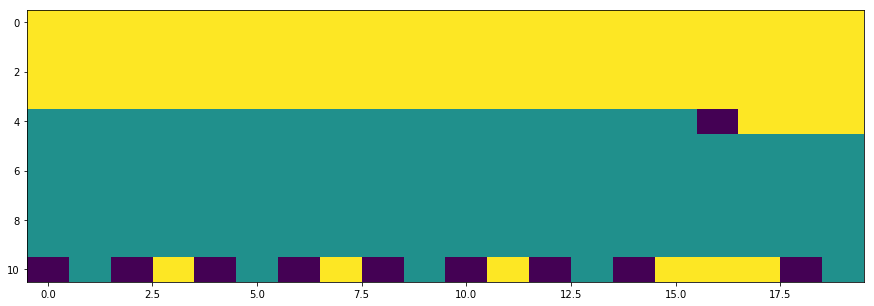

In [248]:
change_indices = np.where(np.any(final_states[:, 1:]!=final_states[:, :-1], axis=0))[0].tolist() + [-1]

plt.figure(figsize=(15, 5))
plt.imshow(final_states[:, change_indices], aspect='auto', vmin=-1, vmax=1)
plt.show()

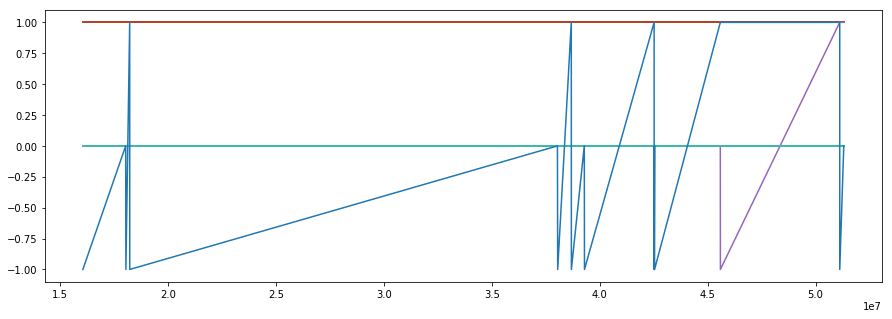

[[       0 16050158]
 [18034367 18034368]
 [18043089 18043090]
 [18219726 18219727]
 [18221312 18221957]
 [38038059 38038060]
 [38047801 38049165]
 [38679640 38679641]
 [38682954 38683636]
 [39282017 39282018]
 [39290137 39290138]
 [42517635 42517636]
 [42518426 42519214]
 [42538617 42538618]
 [42538618 42538668]
 [45583911 45583912]
 [45587269 45587744]
 [51117136 51117137]
 [51117580 51118055]
 [51242557 51304566]]


In [249]:
plt.figure(figsize=(15, 5))
for i in range(final_states.shape[0]):
    plt.plot(family_snp_positions[change_indices, 1], final_states[i, change_indices])
plt.show()
print(family_snp_positions[change_indices, :])

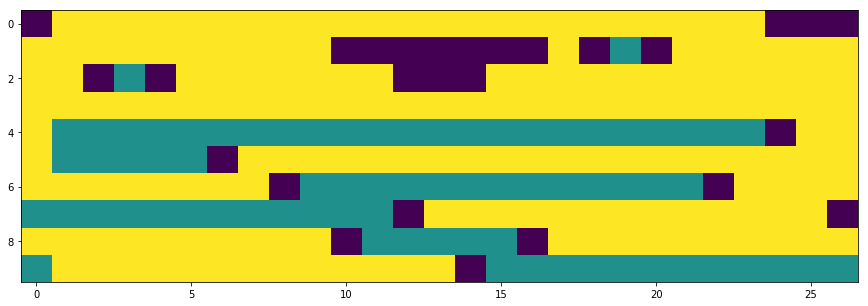

In [167]:
plt.figure(figsize=(15, 5))
plt.imshow(final_states[:, change_indices], aspect='auto', vmin=-1, vmax=1)
plt.show()

In [189]:
print(inds)

['AU045301', 'AU045302', 'AU045306', 'AU045303', 'AU045304']


In [26]:
print(np.min(v_cost[:, -1]))

42686


In [175]:
print(np.min(v_cost[:, -1]))


135445


In [74]:
print(inds)
print(np.min(v_cost[:, -1]))

['AU1249202', 'AU1249201', 'AU1249301', 'AU1249303']
107223
